# Réduction de dimension par ACP

On souhaite diminuer la dimension des séries temporelles (à 4 bandes) pour qu'elles soient univariées pour chaque pixel.

In [1]:
from cookie_clusters import *

In [120]:
from sklearn.decomposition import PCA
import os
import itertools
from PIL import Image
import rasterio as rio
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastdtw as dtw

In [3]:
# List of target pixels
pixels_de_interet, dic_de_pixels = create_dic_pixels()
len(pixels_de_interet)
pixels_de_interet
dic_de_pixels

{'pix_foret': [[472, 570],
  [474, 570],
  [476, 570],
  [478, 570],
  [480, 570],
  [482, 570],
  [484, 570],
  [486, 570],
  [488, 570]],
 'pix_lac': [[392, 567],
  [392, 580],
  [401, 577],
  [401, 567],
  [395, 570],
  [395, 576],
  [397, 571],
  [394, 598],
  [388, 532]],
 'pix_apt': [[405, 448],
  [408, 444],
  [412, 446],
  [412, 463],
  [407, 465],
  [405, 455],
  [414, 440],
  [420, 458],
  [401, 446]],
 'pix_ensta': [[447, 618],
  [454, 627],
  [454, 631],
  [457, 632],
  [459, 625],
  [450, 641],
  [443, 636],
  [439, 629],
  [433, 617]],
 'pix_agri': [[318, 438],
  [322, 435],
  [324, 433],
  [329, 429],
  [333, 426],
  [337, 424],
  [339, 422],
  [344, 418],
  [350, 414]],
 'pix_danone': [[383, 497],
  [383, 500],
  [387, 501],
  [383, 504],
  [387, 505],
  [384, 508],
  [388, 509],
  [384, 504],
  [386, 504]]}

In [4]:
# Pour le fil rouge
dir = "../../../images-fil-rouge"
images_list_original = [x for x in os.listdir(dir) if x.endswith(".tif")]
images_list_original.sort()
images_list_original.pop(21) # On enlève l'image 21 qui est une image erronée)

'crop_SENTINEL2A_20180210-105158-460_L2A_T31UDQ_C_V2-2.tif'

In [5]:
# Getting the pixel values for each image
nband = 4
images_list_beforePCA = np.zeros((len(images_list_original), len(pixels_de_interet), nband))
for image in images_list_original:
    matrice = np.zeros((len(pixels_de_interet),nband))
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)            
        band3 = ds.read(3)
        band4 = ds.read(4)
        # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,0] = band1[pixel[0], pixel[1]]
        matrice[j,1] = band2[pixel[0], pixel[1]]
        matrice[j,2] = band3[pixel[0], pixel[1]]
        matrice[j,3] = band4[pixel[0], pixel[1]]
    images_list_beforePCA[images_list_original.index(image)] = matrice

In [6]:
# Reshaping to apply PCA
images_list_beforePCA.reshape((len(images_list_original)*len(pixels_de_interet),nband)).shape

# Applying PCA with 1 component
pca = PCA(n_components=1)
images_list_afterPCA = pca.fit_transform(images_list_beforePCA.reshape((len(images_list_original)*len(pixels_de_interet),nband)))
images_list_afterPCA = images_list_afterPCA.reshape((len(images_list_original), len(pixels_de_interet)))

In [7]:
# Reshaping into time series
TS_after_pca = images_list_afterPCA.T

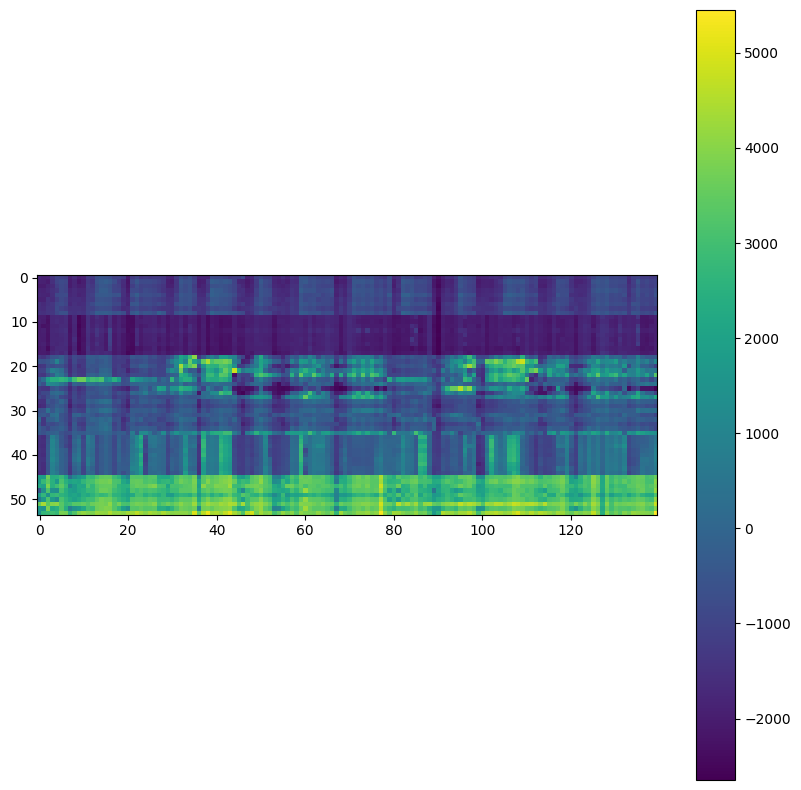

In [8]:
#Looking for a pixels
plt.figure(figsize=(10,10))
plt.imshow(TS_after_pca)
plt.colorbar()
plt.show()

## Clustering

In [9]:
from cookie_clusters import *

yhat = kmeans_dtw(TS_after_pca,6,5000)

,accuracy,f1_score
0,0.685185,0.593162


,calinski_harabasz_score
0,74.09819


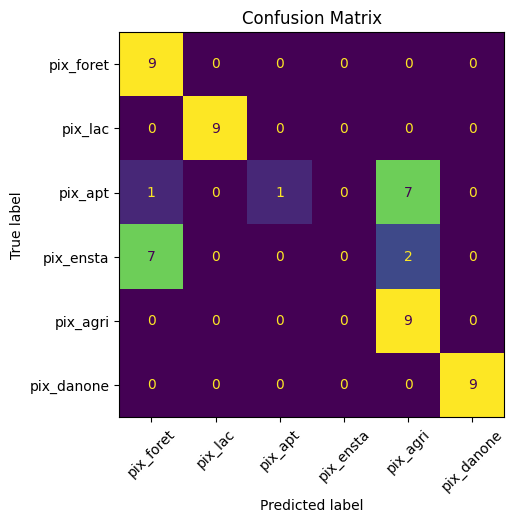

In [10]:
# from cookie_clusters import evaluator_de_experiences

eval_PCA = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA.confusion_matrix()
display(eval_PCA.metrics_classif())
display(eval_PCA.metrics_clustering())

In [11]:
eval_PCA.show_list()

cluster numero 0:
-------------------------------
[401, 577] : pix_lac
[401, 567] : pix_lac
[388, 532] : pix_lac
-------------------------------
cluster numero 1:
-------------------------------
[420, 458] : pix_apt
-------------------------------
cluster numero 2:
-------------------------------
[392, 567] : pix_lac
[392, 580] : pix_lac
[395, 570] : pix_lac
[395, 576] : pix_lac
[397, 571] : pix_lac
[394, 598] : pix_lac
-------------------------------
cluster numero 3:
-------------------------------
[472, 570] : pix_foret
[474, 570] : pix_foret
[476, 570] : pix_foret
[478, 570] : pix_foret
[480, 570] : pix_foret
[482, 570] : pix_foret
[484, 570] : pix_foret
[486, 570] : pix_foret
[488, 570] : pix_foret
[414, 440] : pix_apt
[454, 627] : pix_ensta
[454, 631] : pix_ensta
[457, 632] : pix_ensta
[459, 625] : pix_ensta
[450, 641] : pix_ensta
[443, 636] : pix_ensta
[439, 629] : pix_ensta
-------------------------------
cluster numero 4:
-------------------------------
[405, 448] : pix_apt
[4

,accuracy,f1_score
0,0.740741,0.676046


,calinski_harabasz_score
0,89.508061


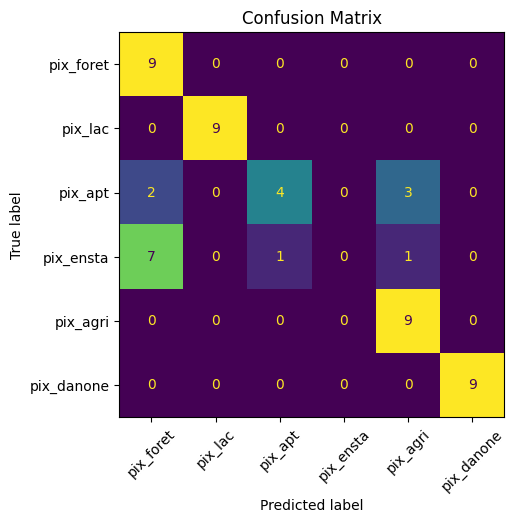

In [12]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

yhat_km = KMeans(n_clusters=6, random_state=0, n_init="auto").fit_predict(TS_after_pca)
eval_PCA_km = evaluator_de_experiences(yhat_km, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_km.confusion_matrix()
display(eval_PCA_km.metrics_classif())
display(eval_PCA_km.metrics_clustering())

In [25]:
TS_after_pca

array([[-1732.21228318, -1894.54090487, -1844.96090608, ...,
        -1152.8155857 , -1296.98387803, -1160.98127377],
       [-1882.72314356, -1904.08932948, -2037.71772377, ...,
         -897.87771044, -1076.30209303, -1007.51086033],
       [-2036.52180489, -2027.29846902, -1807.46441684, ...,
        -1001.44176831, -1159.67030481,  -978.36680887],
       ...,
       [ 3615.48311342,  4373.18412765,  3399.18545393, ...,
         3528.48049751,  3662.80281015,  4766.20307634],
       [ 1698.99886853,  1505.40032914,  3829.04011508, ...,
         3320.09786197,  3199.15615448,  3947.49284969],
       [ 1338.20272056,  2699.68987178,  2827.85685579, ...,
         3904.79251828,  3854.43978056,  5450.17992224]])

In [42]:
import numpy as np

,accuracy,f1_score
0,0.759259,0.697381


,calinski_harabasz_score
0,28.893209


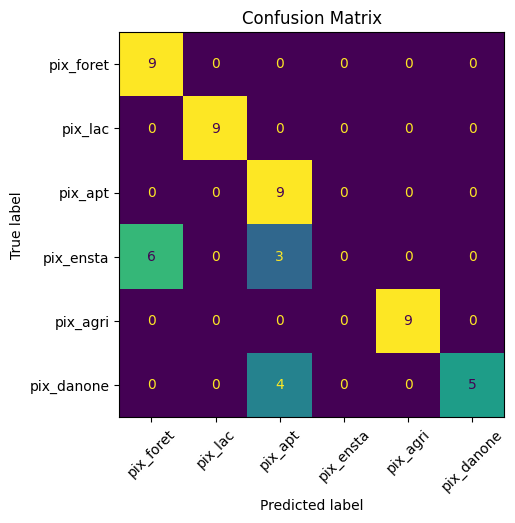

In [61]:
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering

#DBSCAN - euclidien
yhat_dbs = DBSCAN(eps=5000 ,min_samples=3, metric='euclidean').fit_predict(TS_after_pca)
eval_PCA_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_dbs.confusion_matrix()
display(eval_PCA_dbs.metrics_classif())
display(eval_PCA_dbs.metrics_clustering())


,accuracy,f1_score
0,0.62963,0.546296


,calinski_harabasz_score
0,83.913517


(4,)


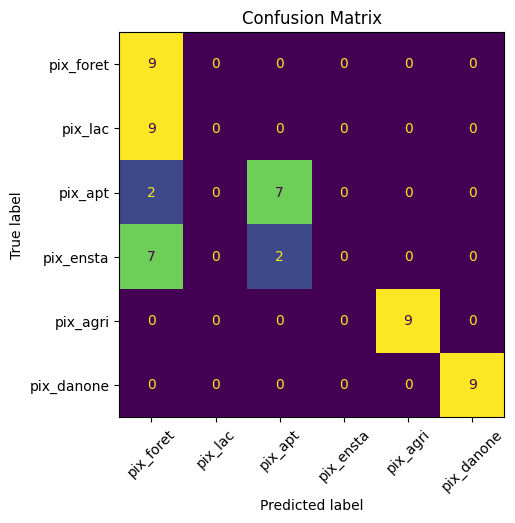

In [114]:
yhat_dbs = DBSCAN(eps=10000 ,min_samples=3, metric='euclidean').fit_predict(TS_after_pca)
eval_PCA_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_dbs.confusion_matrix()
display(eval_PCA_dbs.metrics_classif())
display(eval_PCA_dbs.metrics_clustering())
print(np.unique(yhat_dbs).shape)

24500
24600
24700
24800
24900
25000
25100
25200
25300
25400
25500
25600
25700
25800
25900
26000
26100
26200
26300
26400
26500
26600
26700
26800
26900
27000
27100
27200
27300
27400
27500
27600
27700
27800
27900
28000
28100
28200
28300
28400
28500
28600
28700
28800
28900
29000
29100
29200
29300
29400
29500
29600
29700
29800
29900
30000
30100
30200
30300
30400
30500
30600
30700
30800
30900
31000
31100
31200
31300
31400
31500
31600
31700
31800
31900
32000
32100
32200
32300
32400
32500
32600
32700
32800
32900
33000
33100
33200
33300
33400
33500
33600
33700
33800
33900
34000
34100
34200
34300
34400
34500
34600
34700
34800
34900
35000
35100
35200
35300
35400
35500
35600
35700
35800
35900
36000
36100
36200
36300
36400
36500
36600
36700
36800
36900
37000
37100
37200
37300
37400
37500
37600
37700
37800
37900
38000
38100
38200
38300
38400
38500
38600
38700
38800
38900
39000
39100
39200
39300
39400
39500
39600
39700
39800
39900
40000
40100
40200
40300
40400
40500
40600
40700
40800
40900
41000
4110

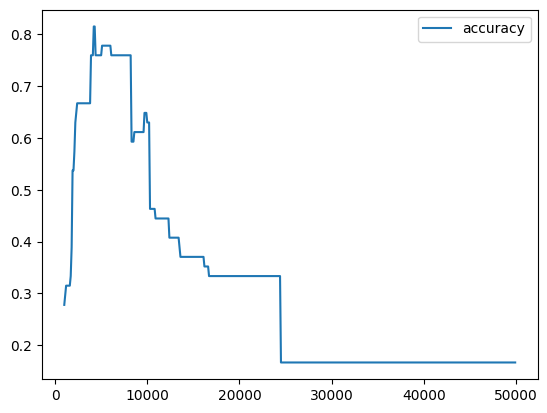

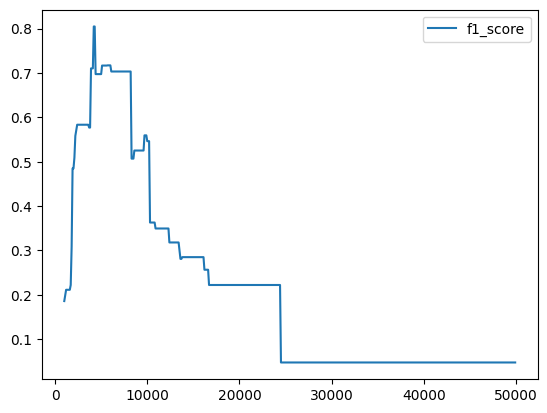

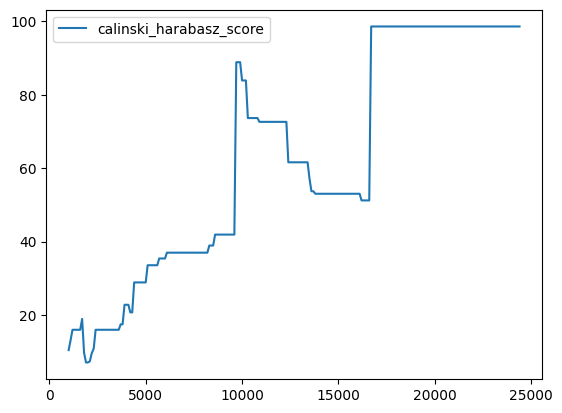

In [112]:
x = np.arange(1000, 50000, 100)
y_a = []
y_f = []
y_chi = []

xi = []

for i in x:
    yhat_dbs = DBSCAN(eps=i ,min_samples=3, metric='euclidean').fit_predict(TS_after_pca)
    eval_PCA_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_pca)

    y_a.append(eval_PCA_dbs.metrics_classif()['accuracy'][0])
    y_f.append(eval_PCA_dbs.metrics_classif()['f1_score'][0])
    try:
        y_chi.append(eval_PCA_dbs.metrics_clustering()['calinski_harabasz_score'][0])
        xi.append(i)
    except ValueError:
        print(i)

plt.plot(x, y_a, label="accuracy")
plt.legend()
plt.show()
plt.plot(x, y_f, label="f1_score")
plt.legend()
plt.show()
plt.plot(xi, y_chi, label="calinski_harabasz_score")
plt.legend()
plt.show()

,accuracy,f1_score
0,0.796296,0.80821


,calinski_harabasz_score
0,8.376819


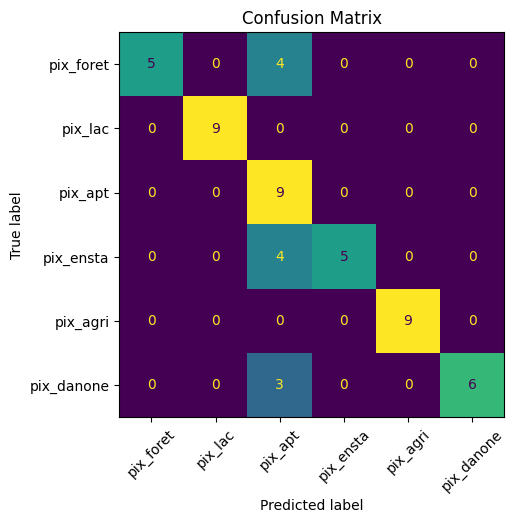

In [115]:
#OPTICS - euclidien
yhat_pts = OPTICS(min_samples=2, metric='euclidean').fit_predict(TS_after_pca)
eval_PCA_pts = evaluator_de_experiences(yhat_pts, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_pts.confusion_matrix()
display(eval_PCA_pts.metrics_classif())
display(eval_PCA_pts.metrics_clustering())



,accuracy,f1_score
0,0.851852,0.843275


,calinski_harabasz_score
0,104.239533


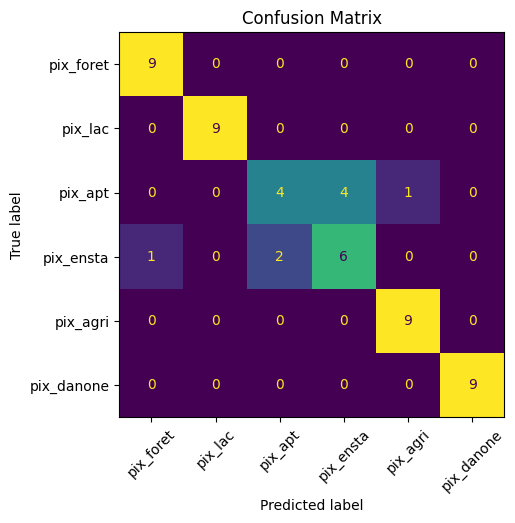

In [30]:
#CAH - euclidien
yhat_cah = AgglomerativeClustering(n_clusters=6, metric='euclidean').fit_predict(TS_after_pca)
eval_PCA_cah = evaluator_de_experiences(yhat_cah, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_cah.confusion_matrix()
display(eval_PCA_cah.metrics_classif())
display(eval_PCA_cah.metrics_clustering())

In [123]:
from scipy import spatial
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

def matrice_dtw(X, distance):
  N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
  R=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
        R[i,j]= dtw.fastdtw(X[i],X[j],dist=distance)[0]
  return R

#mesure de similarité dtw entre deux séries temporelles. x = un pixel sur un intervalle de temps
def dtw_euclidien(x, x_prime):
  R=np.zeros((len(x),len(x_prime)))
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = spatial.distance.euclidean(x[i], x_prime[j]) ** 2
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else math.inf,
          R[i  , j-1] if j > 0             else math.inf,
          R[i-1, j-1] if (i > 0 and j > 0) else math.inf
        )

  return R[-1, -1] ** (1/2)

#pour tester avec le cosin
def dtw_cosine(x, x_prime):
  R=np.zeros((x.shape[0],x_prime.shape[0]))
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = spatial.distance.cosine(x[i], x_prime[j])
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else math.inf,
          R[i  , j-1] if j > 0             else math.inf,
          R[i-1, j-1] if (i > 0 and j > 0) else math.inf
        )

  return R[-1, -1]


#pour faire une matrice de similarité : donne la similarité entre toutes les séries temporelles. la matrice X
def matrice_dtw_euclidien(X):
  N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
  R=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
        R[i,j]=dtw_euclidien(X[i],X[j])
  return R 


#pour tester avec le cosin
def matrice_dtw_cosine(X):
  N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
  R=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
        R[i,j]=dtw_cosine(X[i],X[j])
  return R 


In [142]:
mat = TS_after_pca.reshape((len(pixels_de_interet), len(images_list_original), 1))


In [144]:
matrice_dtw(mat, distance=euclidean)

array([[     0.        ,  27357.94769104,  17448.85167308, ...,
        703767.49352312, 597371.29404961, 730224.43287859],
       [ 27357.94769104,      0.        ,  15093.45914247, ...,
        691225.39194826, 584829.19247476, 717682.33130373],
       [ 17448.85167308,  15093.45914247,      0.        , ...,
        699621.92765553, 593225.72818202, 726078.867011  ],
       ...,
       [703767.49352312, 691225.39194826, 699621.92765553, ...,
             0.        ,  89287.55435962,  50404.45491636],
       [597371.29404961, 584829.19247476, 593225.72818202, ...,
         89287.55435962,      0.        ,  91315.78527343],
       [730224.43287859, 717682.33130373, 726078.867011  , ...,
         50404.45491636,  91315.78527343,      0.        ]])

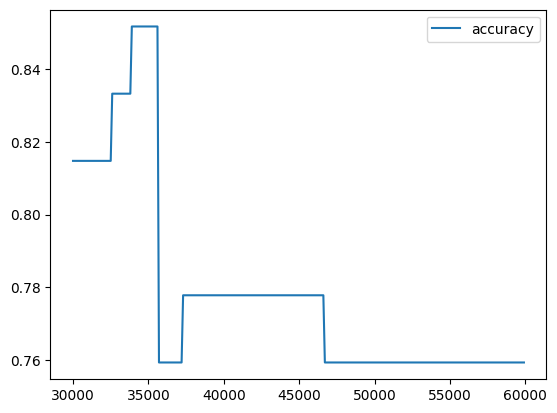

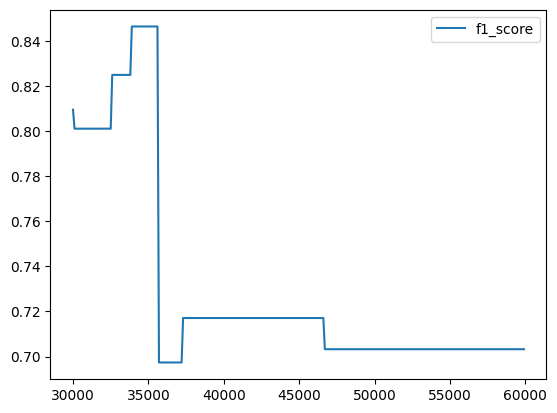

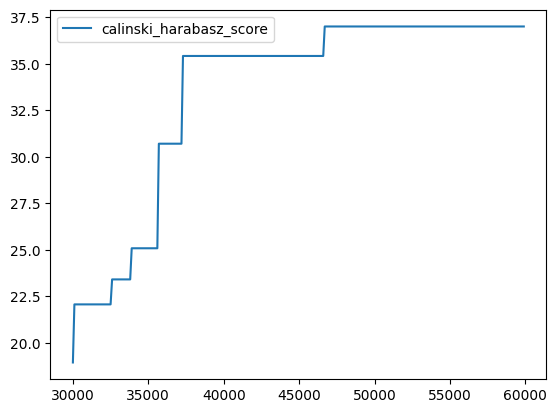

In [151]:
x = np.arange(30000, 60000, 100)
y_a = []
y_f = []
y_chi = []

xi = []

mat_dtw_ACP = matrice_dtw(mat, distance=euclidean)

for i in x:
    yhat_dbs = DBSCAN(eps=i ,min_samples=3, metric='precomputed').fit_predict(mat_dtw_ACP)
    eval_PCA_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_pca)

    y_a.append(eval_PCA_dbs.metrics_classif()['accuracy'][0])
    y_f.append(eval_PCA_dbs.metrics_classif()['f1_score'][0])
    try:
        y_chi.append(eval_PCA_dbs.metrics_clustering()['calinski_harabasz_score'][0])
        xi.append(i)
    except ValueError:
        print(i)

plt.plot(x, y_a, label="accuracy")
plt.legend()
plt.show()
plt.plot(x, y_f, label="f1_score")
plt.legend()
plt.show()
plt.plot(xi, y_chi, label="calinski_harabasz_score")
plt.legend()
plt.show()

,accuracy,f1_score
0,0.777778,0.717101


,calinski_harabasz_score
0,35.41635


(5,)


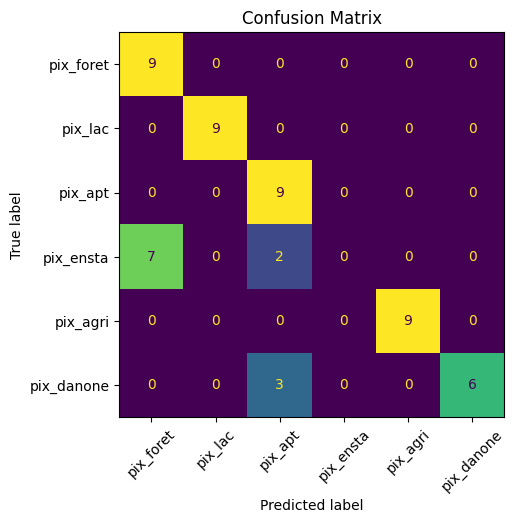

In [153]:
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering

# #DBSCAN - euclidien

yhat_dbs = DBSCAN(eps=40000 ,min_samples=3, metric='precomputed').fit_predict(mat_dtw_ACP)
eval_PCA_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_dbs.confusion_matrix()
display(eval_PCA_dbs.metrics_classif())
display(eval_PCA_dbs.metrics_clustering())
print(np.unique(yhat_dbs).shape)


,accuracy,f1_score
0,0.740741,0.746023


,calinski_harabasz_score
0,9.525062


(11,)


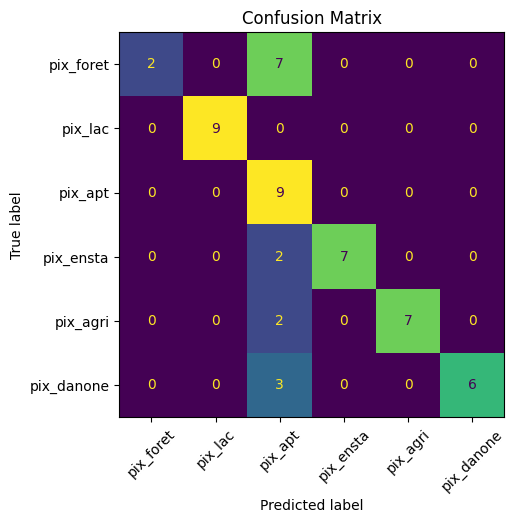

In [154]:
yhat_optics = OPTICS(min_samples=2, metric='precomputed').fit_predict(mat_dtw_ACP)
eval_PCA_optics = evaluator_de_experiences(yhat_optics, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_optics.confusion_matrix()
display(eval_PCA_optics.metrics_classif())
display(eval_PCA_optics.metrics_clustering())
print(np.unique(yhat_optics).shape)

,accuracy,f1_score
0,0.740741,0.67397


,calinski_harabasz_score
0,93.566595


(6,)


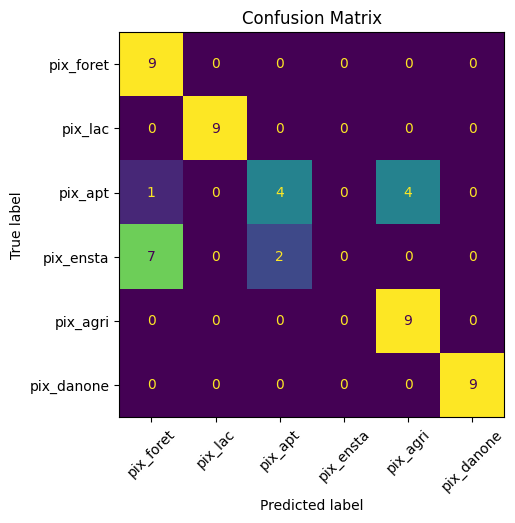

In [156]:
yhat_cah = AgglomerativeClustering(n_clusters=6, metric='precomputed', linkage='complete').fit_predict(mat_dtw_ACP)
eval_PCA_cah = evaluator_de_experiences(yhat_cah, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA_cah.confusion_matrix()
display(eval_PCA_cah.metrics_classif())
display(eval_PCA_cah.metrics_clustering())
print(np.unique(yhat_cah).shape)

In [ ]:

#OPTICS - euclidien
clustering_optics = OPTICS(min_samples=2, metric='precomputed').fit(matrice_dtw_euclidien(TS_after_pca))
labels_optics = clustering_optics.labels_

#CAH - euclidien
clustering_CAH = AgglomerativeClustering(metric='precomputed', linkage='complete').fit(matrice_dtw_euclidien(TS_after_pca))
labels_CAH = clustering_CAH.labels_




In [23]:
TS_after_pca.shape

(54, 140)